# Retraining Windows and Doors Extraction model

## Table of Contents
* [Introduction and objective](#Introduction-and-objective)
* [Download Esri Windows and Doors model](#Download-Esri-Windows-and-Doors-model)
* [Necessary imports](#Necessary-imports)
* [Model training](#Model-training)
 * [Visualize training data](#Visualize-training-data)
 * [Load pretrained model](#Load-pretrained-model)
 * [Train the model](#Train-the-model)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)

## Introduction and objective

Not having the data required for a GIS task is a common problem that GIS users run into. For example, a GIS Analyst performing 3D visibility analysis might need observer locations for all windows in a building, but usually this data is not readily available. In this case, one option for the user is to manually digitize all the windows – needless to say, manually digitizing is a time-consuming process and doing this for many buildings will slow down the analysis workflow. An alternative is to use a trained Deep Learning object-detection model, that can be used to automatically detect and extract objects of interest from data displayed in the current view.

In ArcGIS Pro 2.7, a new [Interactive Object Detection](https://pro.arcgis.com/en/pro-app/latest/help/mapping/exploratory-analysis/interactive-object-detection-basics.htm) tool has been added that can be used for on-demand object detection. This tool runs against content displayed in the active 3D/2D map view, providing a convenient and fast approach to integrating object-detection in existing GIS workflows. The detected objects are extracted as geodatabase features and can be used as inputs for other analysis tools. This tool also comes with a default trained [Windows and Doors Extraction](https://www.arcgis.com/home/item.html?id=8c0078cc7e314e31b20001d94daace5e) model that can be used for detecting windows and doors in 3D building data displayed in 3D scenes.

The Windows and Doors Extraction model has been trained with images from the [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html) and even though the model is expected to work well for a variety of window and door shapes, you might want to fine-tune this model for your specific region or data. By retraining the model you will be able to build on top of the base model and get better results for your scenarios.

This notebook provides step-by-step instructions on how you can retrain the default model.

Before we get started, here are some sample results of windows detected in a ArcGIS Pro 3D scene using the Interactive Object Detection tool. Detected objects are saved as a geodatabase point feature class with attributes for width, height, orientation, confidence score, label and description of each detection.

<b>Detected windows symbolized as points</b>
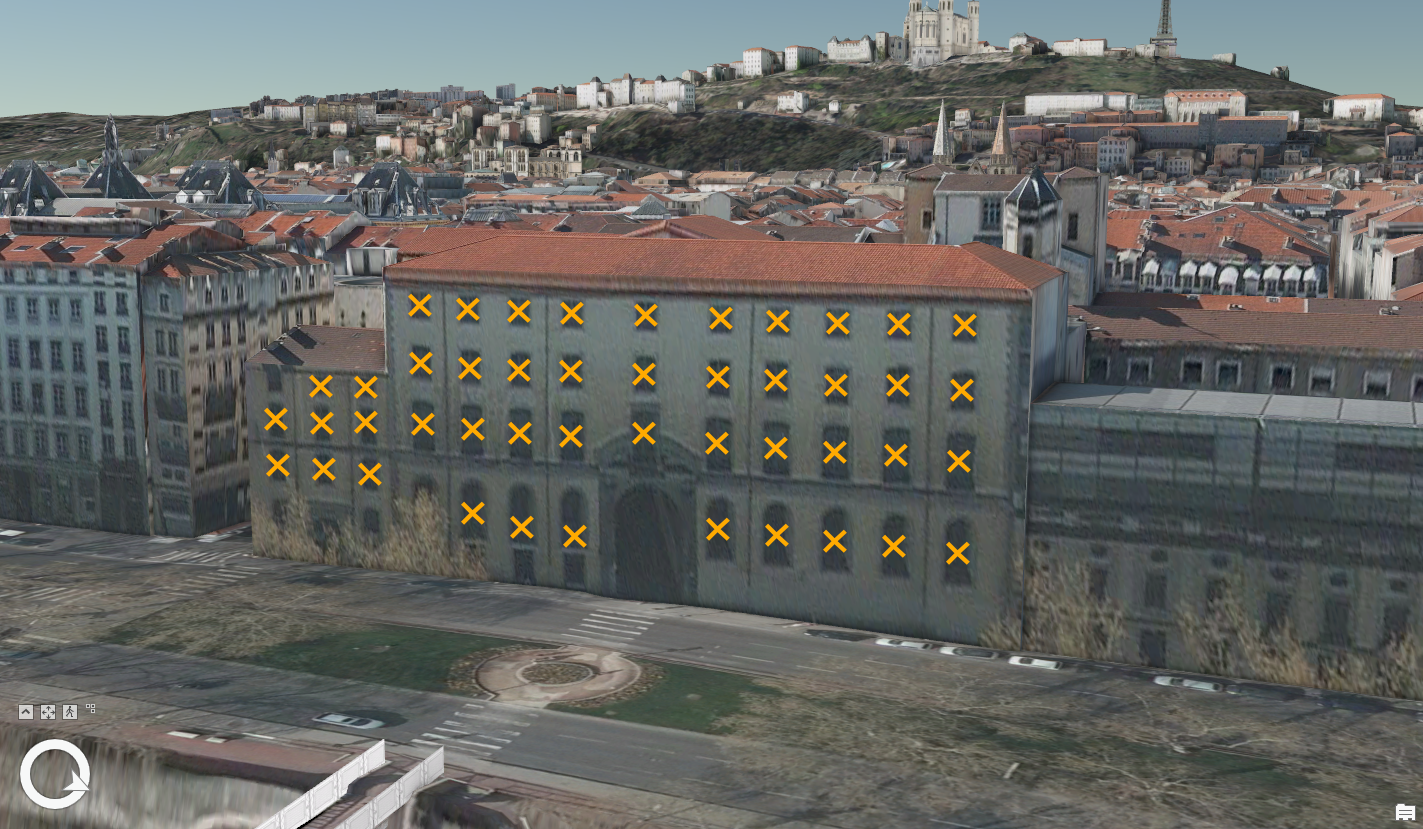
<br><br>

<b>Detected windows symbolized as panels</b>
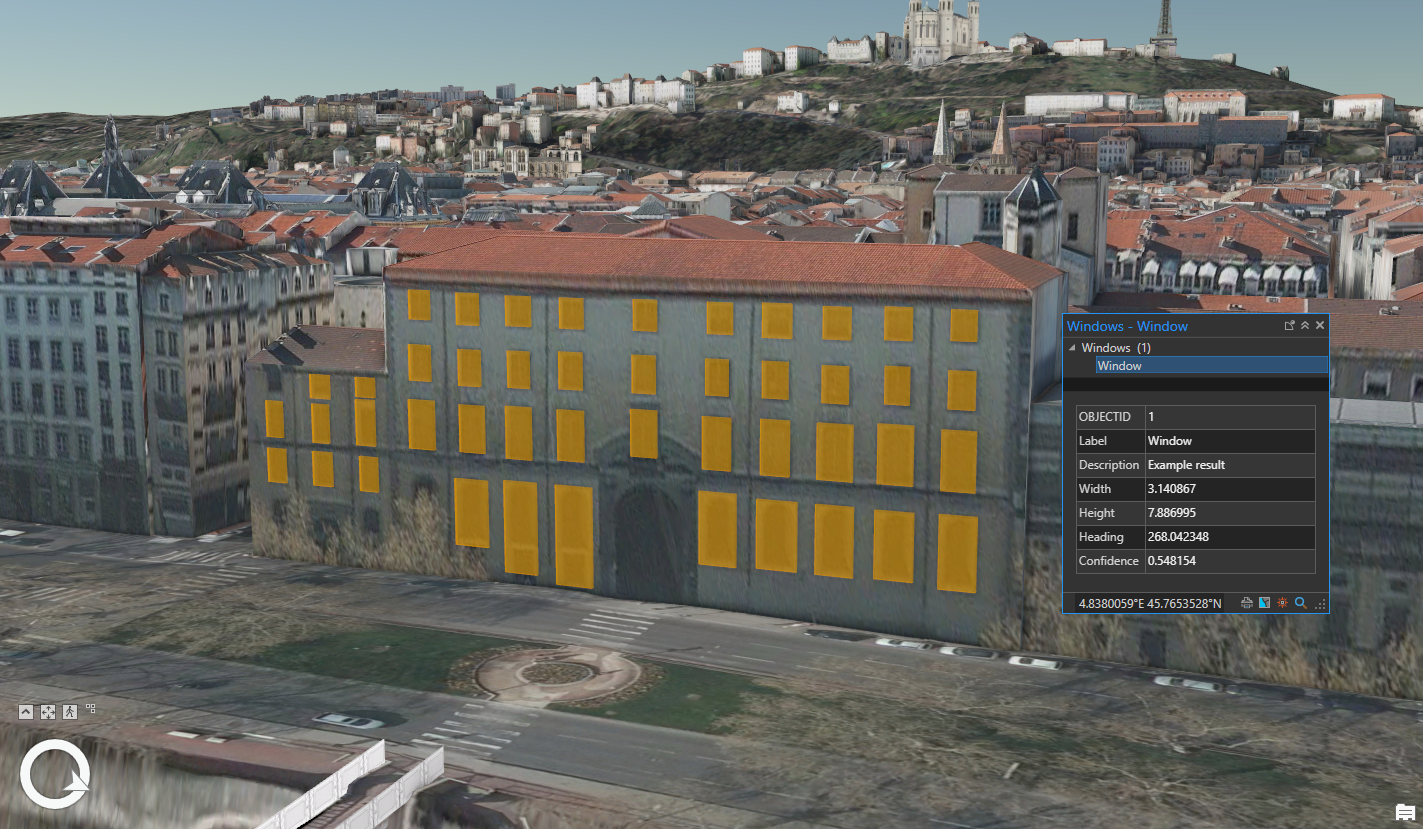

## Download Esri Windows and Doors model

The default <b>Esri Windows and Doors</b> model is accessible from within the ArcGIS Pro Interactive Object Detection tool. However, for retraining you can download the latest version from https://arcgis.com/home/item.html?id=8c0078cc7e314e31b20001d94daace5e

<b>Once downloaded:</b>
* Copy Esri_Windows_and_Doors.dlpk to your working folder.


* Unzip the DLPK - we need to extract contents of the DLPK because when loading the pretrained model, we will pass in path to the Esri Model Definition (.emd) file, which is available in the extracted contents of the DLPK.

## Necessary imports

In [ ]:
import pandas as pd
import os
import shutil
from pathlib import Path

from arcgis.learn import prepare_data, FasterRCNN

## Model training

Change the path to your own training data folder that contains "images" and "labels" folder.

<b>NOTE:</b> The default Esri Windows and Doors model has been trained for detecting windows and doors. Your training data should have at least <b><i><u>one example each</u></i></b> of a window and a door. You will see errors with this retraining code below if you only use training images/labels for windows or doors.

In [ ]:
data_path = 'Path to Training Data'
data_path

``prepare_data`` function takes path to training data and creates a fastai databunch with specified transformation, batch size, split percentage,etc.

In [ ]:
data = prepare_data(data_path,
                    batch_size=4, #reduce batch size if you see CUDA out of memory error during training
                    resize_to = 448,
                    chip_size=448,
                    seed=42,
                    dataset_type='PASCAL_VOC_rectangles')

We can use the classes attribute of the data object to get information about the number of classes.

In [ ]:
data.classes

## Visualize training data

To get a sense of what the training data looks like, use ``arcgis.learn.show_batch()`` method to randomly pick a few training chips and visualize them.

In [ ]:
data.show_batch()

## Load pretrained model

``arcgis.learn`` provides the ``FasterRCNN`` model for object detection tasks, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about FasterRCNN can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.html#fasterrcnn).

``Windows and Doors`` detection model is a ``FasterRCNN`` model. Here we will load the pre-trained default model that you downloaded and copied to your working folder.

In [ ]:
model_def_path = 'Path to Esri Windows and Doors.emd' # Esri Windows and Doors.emd file is in the extracted contents of the DLPK

fcnn = FasterRCNN.from_model(model_def_path, data=data)

Let us have a look at the results of the pretrained model.

In [ ]:
fcnn.show_results(thresh=0.2)

Learning rate is one of the most important hyperparameters in model training. We will use the ``lr_find()`` method to find an optimum learning rate at which we can train a robust model fast enough.

In [ ]:
fcnn.lr_find()

## Train the model

Based on the suggested learning rate above, we will start training our model with 30 epochs. Our training will stop early if validation loss stops improving for 5 epochs.

In [ ]:
#set parameter lr = the learning rate suggested above by lr_find()
fcnn.fit(30, lr=0.00003, early_stopping=True)

``average_precision_score`` method computes average precision on the validation set for each class.

In [ ]:
fcnn.average_precision_score() 

Visualize detection results in validation set

In [ ]:
fcnn.show_results(thresh=0.5, nms_overlap=0.1)

## Save the model

Once the model has been retrained, it can be saved for further training later or for inferencing with the ``Interactive Object Detection`` tool in ArcGIS Pro. By default, it will be saved into your ``data_path`` that you specified earlier in this notebook.

In [ ]:
fcnn.save(str(data_path + '/Retrained_Windows_and_Doors'))

## Model inference

The trained model can be used to run inference on an image and visualize the results as shown below.

In [ ]:
test_img_path = 'Path to test image'

fcnn.predict(test_img_path, threshold=0.5, resize = True, visualize=True)

## Conclusion

In this notebook we saw how you can retrain the default Esri Windows and Doors Extraction model with images that better represent windows and doors in your region or dataset. Once the retrained model has been saved, you can browse to it using the ArcGIS Pro Interactive Object Detection tool and use it for inferencing in 3D scenes.